<a id='top-page'></a>
# <img src="../images/PCAfold-logo.svg" style="height:100px"> Demo for using the cost function for low-dimensional manifold topology optimization

In this tutorial, we present the cost function from the ``analysis`` module which distills information from the normalized variance derivative into a single number. The cost function can be used for low-dimensional manifold topology assessment and manifold optimization. 

- [**Upload a combustion data set**](#data-set)
- [**Generate low-dimensional manifolds using PCA**](#manifolds)
- [**Manifold assessment using the cost function**](#cost-function)
- [**Manifold optimization using the cost function**](#optimization)
***

**Should plots be saved?**

In [11]:
save_plots = False

***

We import the necessary modules:

In [12]:
from PCAfold import preprocess
from PCAfold import reduction
from PCAfold import analysis
import numpy as np

and we set some initial parameters:

In [13]:
save_filename = None

<a id='data-set'></a>
***

## Upload a combustion data set

[**↑ Go to the top**](#top-page)

A data set representing combustion of syngas in air generated from steady laminar flamelet model using [*Spitfire*](https://github.com/sandialabs/Spitfire) software [[1]](#references) and a chemical mechanism by Hawkes et al. [[2]](#references) is used as a demo data set. 

We begin by importing the data set composed of the original state space variables,
$\mathbf{X}$, and the corresponding source terms, $\mathbf{S_X}$:

In [14]:
X = np.genfromtxt('data-state-space.csv', delimiter=',')
S_X = np.genfromtxt('data-state-space-sources.csv', delimiter=',')
X_names = ['T', 'H2', 'O2', 'O', 'OH', 'H2O', 'H', 'HO2', 'CO', 'CO2', 'HCO']

(n_observations, n_variables) = np.shape(X)

<a id='manifolds'></a>
***

## Generate low-dimensional manifolds using PCA

[**↑ Go to the top**](#top-page)

Below, we generate two- and three-dimensional projections of the original data set from PCA for further assessment.

In [15]:
pca_X_2D = reduction.PCA(X, scaling='auto', n_components=2)
Z_2D = pca_X_2D.transform(X)
S_Z_2D = pca_X_2D.transform(S_X, nocenter=True)

In [16]:
pca_X_3D = reduction.PCA(X, scaling='auto', n_components=3)
Z_3D = pca_X_3D.transform(X)
S_Z_3D = pca_X_3D.transform(S_X, nocenter=True)

We visualize the generated manifolds:

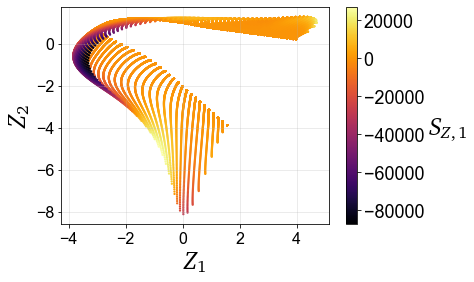

In [17]:
if save_plots: save_filename = '../images/tutorial-cost-function-2D-manifold-SZ1.svg'
plt = reduction.plot_2d_manifold(Z_2D[:,0],
                                 Z_2D[:,1],
                                 color=S_Z_2D[:,0],
                                 s=5,
                                 x_label='$Z_1$',
                                 y_label='$Z_2$',
                                 colorbar_label='$S_{Z,1}$',
                                 color_map='inferno', 
                                 figure_size=(6,4), 
                                 save_filename=save_filename)

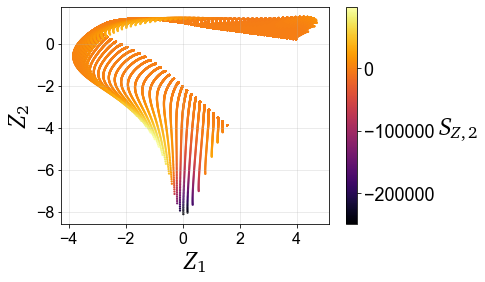

In [18]:
if save_plots: save_filename = '../images/tutorial-cost-function-2D-manifold-SZ2.svg'
plt = reduction.plot_2d_manifold(Z_2D[:,0],
                                 Z_2D[:,1],
                                 color=S_Z_2D[:,1],
                                 s=5,
                                 x_label='$Z_1$',
                                 y_label='$Z_2$',
                                 colorbar_label='$S_{Z,2}$',
                                 color_map='inferno', 
                                 figure_size=(6,4), 
                                 save_filename=save_filename)

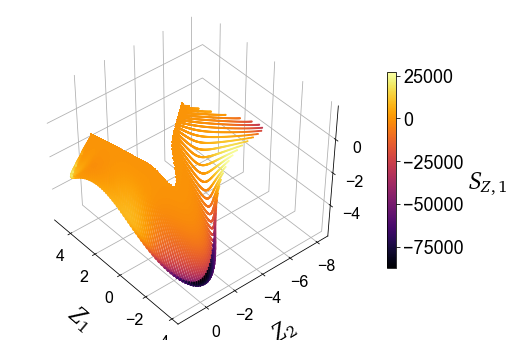

In [19]:
if save_plots: save_filename = '../images/tutorial-cost-function-3D-manifold-SZ1.svg'
plt = reduction.plot_3d_manifold(Z_3D[:,0], 
                                 Z_3D[:,1], 
                                 Z_3D[:,2], 
                                 azim=140,
                                 s=1,
                                 color=S_Z_3D[:,0], 
                                 x_label='$Z_1$', 
                                 y_label='$Z_2$', 
                                 colorbar_label='$S_{Z,1}$', 
                                 color_map='inferno', 
                                 figure_size=(8,6), 
                                 save_filename=save_filename)

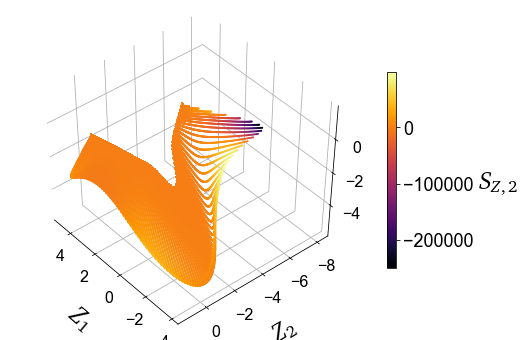

In [20]:
if save_plots: save_filename = '../images/tutorial-cost-function-3D-manifold-SZ2.svg'
plt = reduction.plot_3d_manifold(Z_3D[:,0], 
                                 Z_3D[:,1], 
                                 Z_3D[:,2], 
                                 azim=140,
                                 s=1,
                                 color=S_Z_3D[:,1], 
                                 x_label='$Z_1$', 
                                 y_label='$Z_2$', 
                                 colorbar_label='$S_{Z,2}$', 
                                 color_map='inferno', 
                                 figure_size=(8,6), 
                                 save_filename=save_filename)

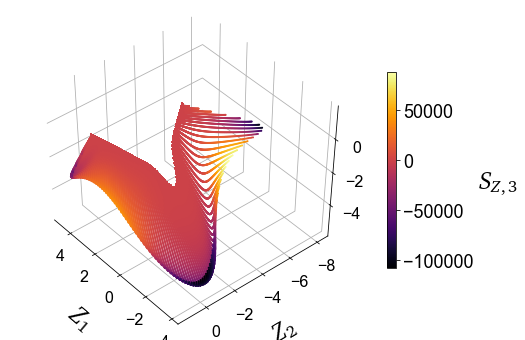

In [30]:
if save_plots: save_filename = '../images/tutorial-cost-function-3D-manifold-SZ3.svg'
plt = reduction.plot_3d_manifold(Z_3D[:,0], 
                                 Z_3D[:,1], 
                                 Z_3D[:,2], 
                                 azim=140,
                                 s=1,
                                 color=S_Z_3D[:,2], 
                                 x_label='$Z_1$', 
                                 y_label='$Z_2$', 
                                 colorbar_label='$S_{Z,3}$', 
                                 color_map='inferno', 
                                 figure_size=(8,6), 
                                 save_filename=save_filename)

<a id='cost-function'></a>
***

## Manifold assessment using the cost function

[**↑ Go to the top**](#top-page)

We are going to compute the cost function for the PC source terms as the target dependent variables. 

We specify the penalty function to use:

In [21]:
penalty_function = 'log-sigma-over-peak'

and the bandwidth values, $\sigma$, for normalized variance derivative computation:

In [22]:
bandwidth_values = np.logspace(-7, 3, 200)

We create lists of the target dependent variables names:

In [23]:
depvar_names_2D = ['SZ' + str(i) for i in range(1,3)]
depvar_names_3D = ['SZ' + str(i) for i in range(1,4)]

and we begin with computing the normalized variance derivative for the two-dimensional PCA projection:

In [24]:
variance_data_2D = analysis.compute_normalized_variance(Z_2D,
                                                        S_Z_2D,
                                                        depvar_names=depvar_names_2D,
                                                        bandwidth_values=bandwidth_values)

The associated costs are computed from the generated object of the `VarianceData` class. With the `norm=None` we do not normalize the costs over all target variables (in this case the PC source terms), instead the output will give us the individual costs for each target variable.

In [25]:
costs_2D = analysis.cost_function_normalized_variance_derivative(variance_data_2D, 
                                                                 penalty_function=penalty_function, 
                                                                 norm=None)

We can print the individual costs:

In [26]:
for i, variable in enumerate(depvar_names_2D):
    print(variable + ':\t' + str(round(costs_2D[i],3)))

SZ1:	3.621
SZ2:	1.249


Finally, we repeat the cost function computation for the three-dimensional PCA projection:

In [27]:
variance_data_3D = analysis.compute_normalized_variance(Z_3D, 
                                                        S_Z_3D, 
                                                        depvar_names=depvar_names_3D,
                                                        bandwidth_values=bandwidth_values)

In [28]:
costs_3D = analysis.cost_function_normalized_variance_derivative(variance_data_3D, 
                                                                 penalty_function=penalty_function, 
                                                                 norm=None)

and we print the individual costs:

In [29]:
for i, variable in enumerate(depvar_names_3D):
    print(variable + ':\t' + str(round(costs_3D[i],3)))

SZ1:	0.846
SZ2:	0.958
SZ3:	1.238


The cost function provides us information about the quality of the low-dimensional data projection with respect to target dependent variables, which in this case were the PC source terms. A higher cost indicates a worse manifold topology. The two topological aspects that the cost function takes into account are non-uniqueness and feature sizes.

We observe that individual costs are higher for the two-dimensional than for the three-dimensional PCA projection. This can be understood from our visualization of the manifolds, where we have seen a significant overlap affecting the first PC source term in particular. With the third manifold parameter added in the three-dimensional projection, the projection quality improves and the costs drop.

Moreover, for the two-dimensional PCA projection, the cost associated with the first PC source term is higher than the cost associated with the second PC source term. This can also be understood by comparing the two-dimensional projections colored by $S_{Z, 1}$ and by $S_{Z, 2}$. The high magnitudes of $S_{Z, 1}$ values occur at the location where the manifold exhibits overlap, while the same overlap does not affect the $S_{Z, 2}$ values to the same extent.

<a id='optimization'></a>
***

## Manifold optimization using the cost function

[**↑ Go to the top**](#top-page)

The `analysis.manifold_informed_backward_elimination` function implements an iterative feature selection algorithm that uses the cost function as an objective function. The algorithm selects an optimal subset of the original state variables that result in an optimized PCA manifold topology. Below, we demonstrate the algorithm on a 10% sample of the original data. The data is sampled to speed-up the calculations for the purpose of this demonstration. In real applications it is recommended to use the full data set.

Sample the original data:

In [31]:
sample_random = preprocess.DataSampler(np.zeros((n_observations,)).astype(int), random_seed=100, verbose=False)
(idx_sample, _) = sample_random.random(10)

sampled_X = X[idx_sample,:]
sampled_S_X = S_X[idx_sample,:]

Specify the target variables to assess on the manifold (we will also add the PC source terms to the target variables by setting `add_transformed_source=True`). In this case we take the temperature, $T$, and several important chemical species mass fractions: $H_2$, $O_2$, $H_2O$, $CO$ and $CO_2$:

In [32]:
target_variables = sampled_X[:,[0,1,2,5,8,9]]

Set the norm to take over all target dependent variables:

In [33]:
norm = 'cumulative'

Set the target manifold dimensionality:

In [34]:
q = 2

Run the algorithm:

In [35]:
_, selected_variables, _, _ = analysis.manifold_informed_backward_elimination(sampled_X,
                                                                              sampled_S_X,
                                                                              X_names,
                                                                              scaling='auto',
                                                                              bandwidth_values=bandwidth_values,
                                                                              target_variables=target_variables,
                                                                              add_transformed_source=True,
                                                                              target_manifold_dimensionality=q,
                                                                              penalty_function=penalty_function,
                                                                              norm=norm,
                                                                              verbose=True)

Optimizing...

Iteration No.1
Currently eliminating variable from the following list: 
['T', 'H2', 'O2', 'O', 'OH', 'H2O', 'H', 'HO2', 'CO', 'CO2', 'HCO']
	Currently eliminated variable: T
	Running PCA for a subset:
	H2, O2, O, OH, H2O, H, HO2, CO, CO2, HCO
	Cost:	9.9554
	Currently eliminated variable: H2
	Running PCA for a subset:
	T, O2, O, OH, H2O, H, HO2, CO, CO2, HCO
	Cost:	9.7174
	Currently eliminated variable: O2
	Running PCA for a subset:
	T, H2, O, OH, H2O, H, HO2, CO, CO2, HCO
	Cost:	11.3825
	Currently eliminated variable: O
	Running PCA for a subset:
	T, H2, O2, OH, H2O, H, HO2, CO, CO2, HCO
	Cost:	12.1157
	Currently eliminated variable: OH
	Running PCA for a subset:
	T, H2, O2, O, H2O, H, HO2, CO, CO2, HCO
	Cost:	10.6924
	Currently eliminated variable: H2O
	Running PCA for a subset:
	T, H2, O2, O, OH, H, HO2, CO, CO2, HCO
	Cost:	10.7425
	Currently eliminated variable: H
	Running PCA for a subset:
	T, H2, O2, O, OH, H2O, HO2, CO, CO2, HCO
	Cost:	10.4837
	Currently eliminated

Finally, we generate the PCA projection of the optimized subset of the original data set:

In [36]:
pca_X_optimized = reduction.PCA(X[:,selected_variables], scaling='auto', n_components=2)
Z_optimized = pca_X_optimized.transform(X[:,selected_variables])
S_Z_optimized = pca_X_optimized.transform(S_X[:,selected_variables], nocenter=True)

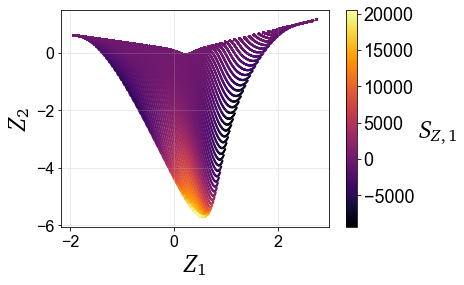

In [37]:
if save_plots: save_filename = '../images/tutorial-cost-function-2D-optimized-manifold-SZ1.svg'
plt = reduction.plot_2d_manifold(Z_optimized[:,0],
                                 Z_optimized[:,1],
                                 color=S_Z_optimized[:,0],
                                 s=5,
                                 x_label='$Z_1$',
                                 y_label='$Z_2$',
                                 colorbar_label='$S_{Z,1}$',
                                 color_map='inferno', 
                                 figure_size=(6,4), 
                                 save_filename=save_filename)

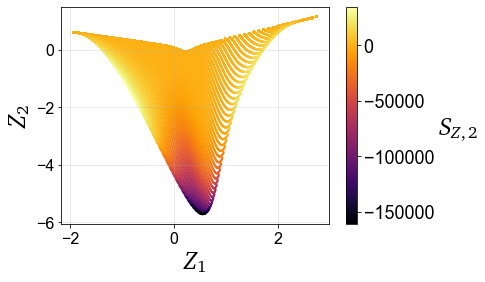

In [38]:
if save_plots: save_filename = '../images/tutorial-cost-function-2D-optimized-manifold-SZ2.svg'
plt = reduction.plot_2d_manifold(Z_optimized[:,0],
                                 Z_optimized[:,1],
                                 color=S_Z_optimized[:,1],
                                 s=5,
                                 x_label='$Z_1$',
                                 y_label='$Z_2$',
                                 colorbar_label='$S_{Z,2}$',
                                 color_map='inferno',
                                 figure_size=(6,4), 
                                 save_filename=save_filename)

From the plots above, we observe that the optimized two-dimensional PCA projection exhibits much less overlap compared to the two-dimensional PCA projection that we computed earlier using the full data set.

Below, we compute the costs for the two PC source terms again for this optimized projection:

In [39]:
variance_data_optimized = analysis.compute_normalized_variance(Z_optimized, 
                                                               S_Z_optimized, 
                                                               depvar_names=depvar_names_2D,
                                                               bandwidth_values=bandwidth_values)

In [40]:
costs_optimized = analysis.cost_function_normalized_variance_derivative(variance_data_optimized, 
                                                                        penalty_function=penalty_function, 
                                                                        norm=None)

In [41]:
for i, variable in enumerate(depvar_names_2D):
    print(variable + ':\t' + str(round(costs_optimized[i],3)))

SZ1:	1.357
SZ2:	0.831


We note that the costs for the two PC source terms are lower than the costs that we computed earlier using the full data set to generate the PCA projection.

<a id='references'></a>
***

## References

[**↑ Go to the top**](#top-page)

> [[1]](#data-set) [M. A. Hansen, *Spitfire*, 2020](https://github.com/sandialabs/Spitfire)
> 
> [[2]](#data-set) E.R. Hawkes, R. Sankaran, J.C. Sutherland, J.H. Chen, *Scalar mixing in direct numerical simulations of temporally evolving plane jet flames with skeletal CO/H2 kinetics*, Proceedings of the combustion institute 31 (1) (2007) 1633–1640

***